In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import snntorch

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean, stdev
from sklearn.metrics import confusion_matrix, accuracy_score
from importnb import Notebook
import tqdm
import copy

In [2]:
with Notebook():
    from Preprocessing import *

In [3]:
data.shape, labels.shape

(torch.Size([9315, 6, 4096]), torch.Size([9315, 3]))

In [4]:
data = common_average_referencing(normalize(data, dim=2), dim=1)
classes = labels[:, 1]

In [5]:
mask1 = labels[:, 0] == modalities.index("Imagined")
mask2 = labels[:, 2] == artifacts.index("None")
mask3 = labels[:, 1] <= stimuli.index("U")
mask = mask1 & mask2 & mask3

In [6]:
# Make training and test sets. 80% 10% 10% split.
torch.manual_seed(42)
half = torch.rand_like(mask, dtype=torch.float) < 0.5
train_mask = mask & (torch.rand_like(mask, dtype=torch.float) < 0.8)
valid_mask = mask & ~train_mask & half
test_mask = mask & ~train_mask & ~half

In [7]:
batch_size = 64
epochs = 10
lr =  0.0001
runs = 2

In [8]:
components = ica(downsample(bandpass_filter(robust_scaler(data))))

In [9]:
components.shape, components[0]

(torch.Size([9315, 6, 512]),
 tensor([[-0.0041,  0.0016, -0.0003,  ...,  0.0082,  0.0035, -0.0059],
         [-0.0048,  0.0014, -0.0004,  ..., -0.0234, -0.0229, -0.0191],
         [-0.0108,  0.0022, -0.0012,  ..., -0.0229, -0.0198, -0.0241],
         [-0.0171,  0.0046, -0.0009,  ..., -0.0469, -0.0452, -0.0481],
         [ 0.0250, -0.0051,  0.0027,  ...,  0.0589,  0.0599,  0.0667],
         [-0.0342,  0.0067, -0.0034,  ..., -0.0327, -0.0513, -0.0791]]))

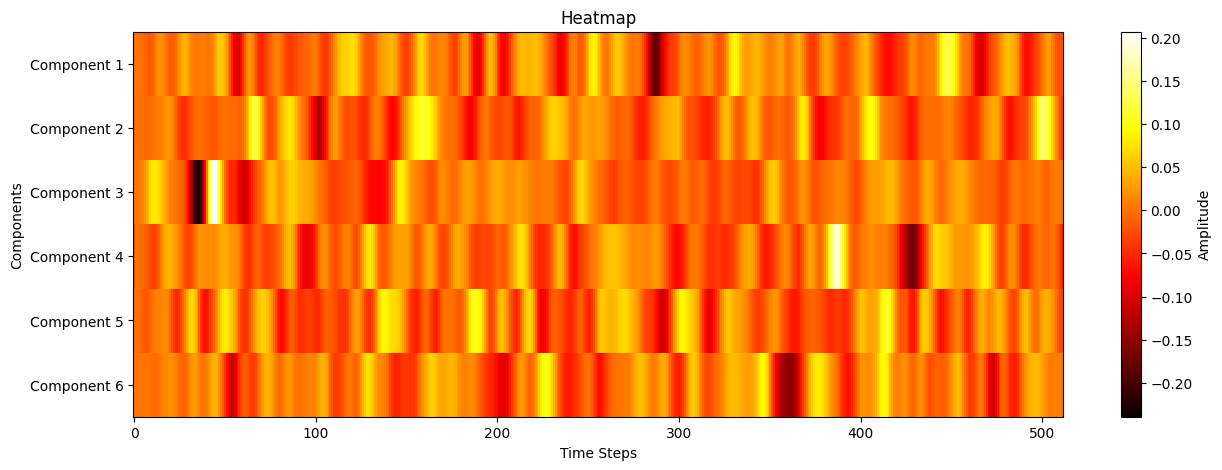

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(components[train_mask][0].numpy(), aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Steps')
plt.ylabel('Components')
plt.title('Heatmap')
plt.yticks(range(components.size(1)), [f'Component {i+1}' for i in range(components.size(1))])
plt.show()

In [11]:
train_loader = DataLoader(TensorDataset(components[train_mask], classes[train_mask]), batch_size=batch_size)
valid_loader = DataLoader(TensorDataset(components[valid_mask], classes[valid_mask]), batch_size=batch_size,)
test_loader = DataLoader(TensorDataset(components[test_mask], classes[test_mask]), batch_size=batch_size)

In [12]:
class SimpleEEGCNN(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.1):
        super(SimpleEEGCNN, self).__init__()

        # Temporal convolution layer
        self.temporal_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 50), stride=(1,1), padding=(0,25)),
            nn.BatchNorm2d(16),
            nn.LeakyReLU()
        )
        
        # Spatial (cross component) convolution layer
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(6,1), stride=(1,1)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )
        
        # Convolutional blocks
        self.conv_blocks = nn.Sequential(
            self._conv_block(32, 64, dropout_rate),
            self._conv_block(64, 128, dropout_rate),
            self._conv_block(128, 256, dropout_rate)
        )

        # Fully connected layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 8, num_classes)
        )

    def _conv_block(self, in_channels, out_channels, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=(1,10), 
                      stride=(1,1),
                      padding=(0,5)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.AvgPool2d(kernel_size=(1,4))
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.temporal_conv(x)
        x = self.spatial_conv(x)
        x = self.conv_blocks(x)
        x = self.classifier(x)
        return x

In [13]:
## NB o1 adapted the above to closely match the code from the paper
## "Rethinking the Methods and Algorithms for Inner Speech Decoding"
## Initialization code and data format fixes were added.

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def matlab_like_init(module):
    """
    Imitate MATLAB's default weight initialization for layers in a PyTorch module:
      - He (Kaiming) initialization for Conv2d (assuming ReLU/LeakyReLU).
      - Zeros for biases.

    This function can be passed to `apply()` on your model.
    """
    if isinstance(module, nn.Conv2d):
        # MATLAB typically uses 'He' initialization for layers with ReLU.
        # PyTorch has a built-in kaiming_normal_ that matches He’s method.
        nn.init.kaiming_normal_(
            module.weight, 
            a=0.0,              # negative_slope=0 for ReLU, or 0.01 for LeakyReLU
            mode='fan_out', 
            nonlinearity='relu' 
        )
        if module.bias is not None:
            nn.init.zeros_(module.bias)
            
    elif isinstance(module, nn.Linear):
        # For fully-connected layers, MATLAB often uses Glorot or He depending on the activation.
        # Here, let’s do the same He init if we assume a ReLU/LeakyReLU after Linear.
        nn.init.kaiming_normal_(
            module.weight,
            a=0.0, 
            mode='fan_out', 
            nonlinearity='relu'
        )
        if module.bias is not None:
            nn.init.zeros_(module.bias)
            
    elif isinstance(module, nn.BatchNorm2d):
        # BatchNorm scale (weight) default = 1, shift (bias) default = 0
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
    # Otherwise, do nothing for layers we haven't covered.



class EEGNetCNN(nn.Module):
    """
    A PyTorch replication of the MATLAB CNN pipeline for EEG vowels/words.
    Defaults to the vowel architecture in 'Trainin_code_vowel.m',
    but can be adapted for words by changing numF, dropout, num_classes, etc.
    """
    def __init__(
        self, 
        num_classes=5,   # vowels=5, words=6
        numF=20,         # base # of filters (MATLAB used 20 for vowels, 40 for words)
        dropout=0.0002,  # dropout rate used in MATLAB
        in_channels=1    # we have 1 “grayscale channel” in the input
    ):
        super(EEGNetCNN, self).__init__()
        
        # --------------- BLOCK 1: “Conv(1x5) → Conv(6x1) → BN → LeakyReLU” ---------------
        self.conv1 = nn.Conv2d(
            in_channels   = in_channels,   # 1
            out_channels  = numF,          # e.g. 20
            kernel_size   = (1, 5),        # [1,5] in MATLAB
            stride        = (1, 1),
            padding       = 0              # 'valid' in MATLAB
        )
        self.conv2 = nn.Conv2d(
            in_channels   = numF,
            out_channels  = numF,          # stays at numF
            kernel_size   = (6, 1),        # [6,1] in MATLAB, collapses electrode dimension
            stride        = (1, 1),
            padding       = 0
        )
        self.bn1    = nn.BatchNorm2d(numF)
        self.act1   = nn.LeakyReLU(negative_slope=0.01)
        
        # --------------- BLOCK 2: “Dropout → Conv(1x5) → BN → LeakyReLU → AvgPool(1x2)” ---------------
        self.drop2   = nn.Dropout(p=dropout)
        self.conv3   = nn.Conv2d(
            in_channels  = numF,
            out_channels = numF,           # still numF
            kernel_size  = (1, 5),
            stride       = (1, 1),
            padding      = 0
        )
        self.bn2   = nn.BatchNorm2d(numF)
        self.act2  = nn.LeakyReLU(negative_slope=0.01)
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 2))
        
        # --------------- BLOCK 3: “Dropout → Conv(1x3, 2*numF) → BN → LeakyReLU → AvgPool(1x2)” ---------------
        self.drop3   = nn.Dropout(p=dropout)
        self.conv4   = nn.Conv2d(
            in_channels  = numF,
            out_channels = 2 * numF,       # 2*numF
            kernel_size  = (1, 3),
            stride       = (1, 1),
            padding      = 0
        )
        self.bn3   = nn.BatchNorm2d(2 * numF)
        self.act3  = nn.LeakyReLU(negative_slope=0.01)
        self.pool3 = nn.AvgPool2d(kernel_size=(1, 2))
        
        # --------------- BLOCK 4: “Dropout → Conv(1x3, 100) → BN → LeakyReLU → AvgPool(1x2)” ---------------
        self.drop4   = nn.Dropout(p=dropout)
        self.conv5   = nn.Conv2d(
            in_channels  = 2 * numF,
            out_channels = 100,
            kernel_size  = (1, 3),
            stride       = (1, 1),
            padding      = 0
        )
        self.bn4   = nn.BatchNorm2d(100)
        self.act4  = nn.LeakyReLU(negative_slope=0.01)
        self.pool4 = nn.AvgPool2d(kernel_size=(1, 2))
        
        # --------------- BLOCK 5: “Dropout → Conv(1x3, 250) → BN → LeakyReLU → AvgPool(1x2)” ---------------
        self.drop5   = nn.Dropout(p=dropout)
        self.conv6   = nn.Conv2d(
            in_channels  = 100,
            out_channels = 250,
            kernel_size  = (1, 3),
            stride       = (1, 1),
            padding      = 0
        )
        self.bn5   = nn.BatchNorm2d(250)
        self.act5  = nn.LeakyReLU(negative_slope=0.01)
        self.pool5 = nn.AvgPool2d(kernel_size=(1, 2))
        
        # --------------- BLOCK 6: “Dropout → Conv(1x3, 500) → BN → LeakyReLU → AvgPool(1x2)” ---------------
        self.drop6   = nn.Dropout(p=dropout)
        self.conv7   = nn.Conv2d(
            in_channels  = 250,
            out_channels = 500,
            kernel_size  = (1, 3),
            stride       = (1, 1),
            padding      = 0
        )
        self.bn6   = nn.BatchNorm2d(500)
        self.act6  = nn.LeakyReLU(negative_slope=0.01)
        self.pool6 = nn.AvgPool2d(kernel_size=(1, 2))
        
        # --------------- Fully Connected Layer ---------------
        # After all these strides, the time dimension will be reduced.
        # If input is [N, 1, 6, 512], after:
        #   conv1(1x5) -> shape [N, numF, 6, 512-4=508]
        #   conv2(6x1) -> shape [N, numF, 1, 508]
        #   conv3(1x5) -> shape [N, numF, 1, 504]
        #   pool2(1,2) -> shape [N, numF, 1, 252]
        #   conv4(1x3) -> shape [N, 2*numF, 1, 250]
        #   pool3(1,2) -> shape [N, 2*numF, 1, 125]
        #   conv5(1x3) -> shape [N, 100, 1, 123]
        #   pool4(1,2) -> shape [N, 100, 1, 61]
        #   conv6(1x3) -> shape [N, 250, 1, 59]
        #   pool5(1,2) -> shape [N, 250, 1, 29]
        #   conv7(1x3) -> shape [N, 500, 1, 27]
        #   pool6(1,2) -> shape [N, 500, 1, 13]
        #
        # So the final feature map is [N, 500, 1, 13] => 500*13 = 6500 features
        #
        self.fc = nn.Linear(500 * 13, num_classes)

        self.apply(matlab_like_init)

    def forward(self, x):
        """
        Forward pass. 
        x shape: [N, 1, 6, 512]
        """
        x = x.unsqueeze(1)
        # -- BLOCK 1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        # -- BLOCK 2
        x = self.drop2(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # -- BLOCK 3
        x = self.drop3(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        # -- BLOCK 4
        x = self.drop4(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.pool4(x)
        
        # -- BLOCK 5
        x = self.drop5(x)
        x = self.conv6(x)
        x = self.bn5(x)
        x = self.act5(x)
        x = self.pool5(x)
        
        # -- BLOCK 6
        x = self.drop6(x)
        x = self.conv7(x)
        x = self.bn6(x)
        x = self.act6(x)
        x = self.pool6(x)
        
        # Flatten
        # shape = [N, 500, 1, 13] => [N, 500*13]
        x = x.reshape(x.size(0), -1)
        
        # Fully connected
        x = self.fc(x)
        return x

In [14]:
epics = []
for run in range(runs):
    net = EEGNetCNN(num_classes=5, numF=20, dropout=0.0002)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=1e-3,
        weight_decay=1e-3
    )

    #net = SimpleEEGCNN(num_classes=5, dropout_rate=0.1)
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    #criterion = nn.CrossEntropyLoss()
    
    losses = []
    valid_losses = []
    progress = tqdm.tqdm(range(epochs), unit="epoch")
    
    for epoch in progress:
        batch_losses = []
        net.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        valid_batch_losses = []
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for valid_inputs, valid_targets in valid_loader:
                valid_outputs = net(valid_inputs)
                loss = criterion(valid_outputs, valid_targets)
                valid_batch_losses.append(loss.item())
                _, predicted = torch.max(valid_outputs, 1)
                correct += (predicted == valid_targets).sum().item()
                total += valid_targets.size(0)
        
        train_loss = mean(batch_losses)
        valid_loss = mean(valid_batch_losses)
        valid_acc = correct / total
        
        losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if valid_losses[-1] == min(valid_losses):
            epic = copy.deepcopy(net.state_dict())
        
        progress.set_description(f'Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
    
    epics.append(epic)

Loss: 0.2096, Validation Loss: 20.9618, Validation Accuracy: 0.2759: 100%|██████████| 10/10 [01:11<00:00,  7.16s/epoch]
Loss: 0.3106, Validation Loss: 21.0043, Validation Accuracy: 0.2146: 100%|██████████| 10/10 [01:16<00:00,  7.63s/epoch]


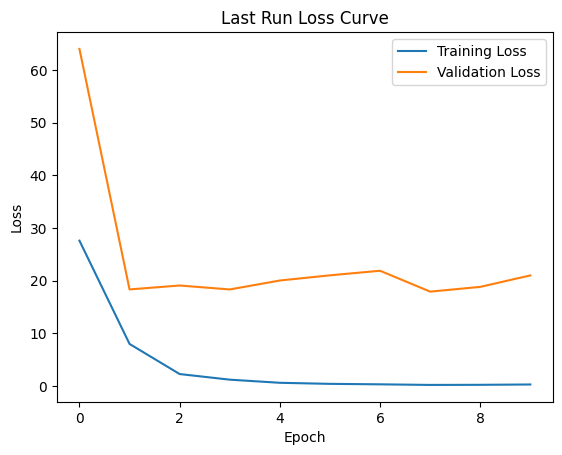

In [15]:
plt.figure()
plt.plot(losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Last Run Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuaracy M: 0.22605363984674332 SD: 0.021673771070852037


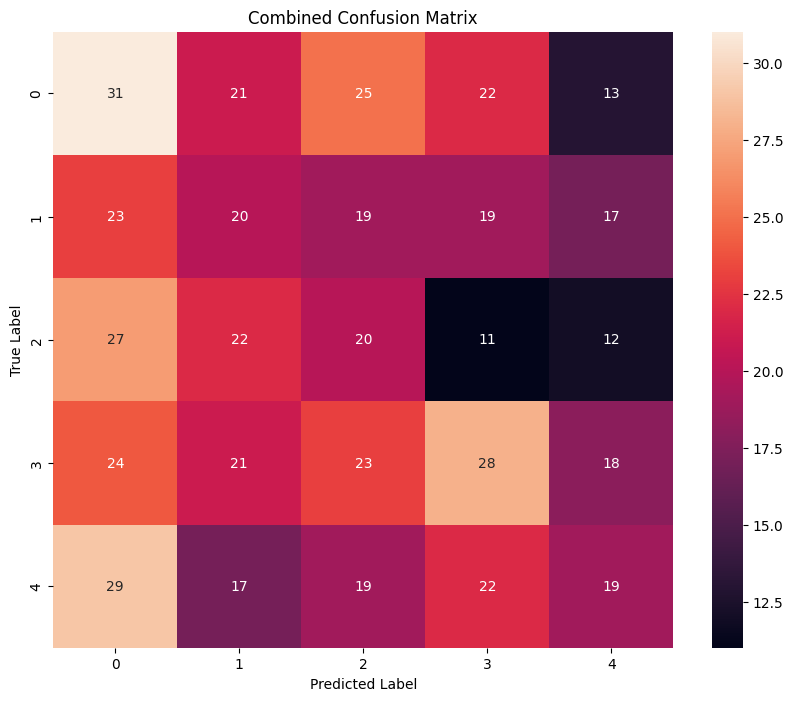

In [16]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    valid_predictions = []
    valid_targets = []
    with torch.no_grad():
        for events, targets in valid_loader:
            logits = net(events)
            predictions = torch.argmax(logits, dim=1)
            valid_predictions += predictions.tolist()
            valid_targets += targets.tolist()
    scores += [(valid_targets, valid_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuaracy M: 0.19488188976377951 SD: 0.019487194757109562


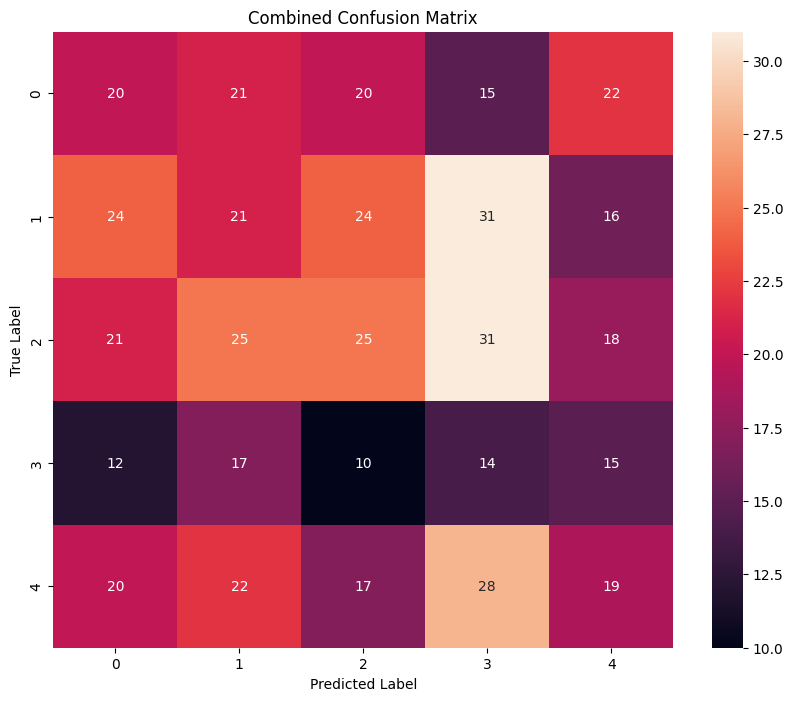

In [17]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for events, targets in test_loader:
            logits = net(events)
            predictions = torch.argmax(logits, dim=1)
            test_predictions += predictions.tolist()
            test_targets += targets.tolist()
    scores += [(test_targets, test_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
def bootstrap_indicies_from_mask(x):
    '''Sorted sampling of the mask with replacement.
    Input is boolean and mask output are indicies.'''
    indicies = torch.arange(len(x))[x]
    drawn_indicies = indicies[torch.randint(0, len(indicies), indicies.shape)]
    return torch.sort(drawn_indicies).values


In [19]:
epics = []
for run in range(runs):
    indicies = bootstrap_indicies_from_mask(train_mask)
    bootstrap_loader = DataLoader(TensorDataset(components[indicies], classes[indicies]),
                                  batch_size=batch_size)

    net = LifParClassifier(input_size=spikes.size(1),
                           hidden_size=hidden_size,
                           output_size=5,
                           layers=layers,
                           gain=gain,
                           bias=bias)
    optimizer = torch.optim.Adagrad(net.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    valid_losses = []
    progress = tqdm.tqdm(range(epochs), unit="epoch")
    for epoch in progress:
        batch_losses = []
        net.train()    
        for events, targets in bootstrap_loader:
            optimizer.zero_grad()
            logits = net(events)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            batch_losses += [loss.item()]
    
        valid_batch_losses = []
        net.eval()
        with torch.no_grad():
            for events, targets in valid_loader:
                logits = net(events)
                loss = criterion(logits, targets)
                valid_batch_losses += [loss.item()]
                
        losses += [mean(batch_losses)]
        valid_losses += [mean(valid_batch_losses)]
    
        if valid_losses[-1] == min(valid_losses):
            epic = copy.deepcopy(net.state_dict())
        
        progress.set_description(f'Loss: {losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f},')
    epics += [epic]

NameError: name 'LifParClassifier' is not defined

In [ ]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    valid_predictions = []
    valid_targets = []
    with torch.no_grad():
        for events, targets in valid_loader:
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            predictions = torch.argmax(logits, dim=1)
            valid_predictions += predictions.tolist()
            valid_targets += targets.tolist()
    scores += [(valid_targets, valid_predictions)]

scores = [tuple(torch.mode(torch.tensor(scores), dim=0).values)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies))

cm = confusion_matrix(*scores[0])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Ensamble Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for events, targets in test_loader:
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            predictions = torch.argmax(logits, dim=1)
            test_predictions += predictions.tolist()
            test_targets += targets.tolist()
    scores += [(test_targets, test_predictions)]

scores = [tuple(torch.mode(torch.tensor(scores), dim=0).values)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies))

cm = confusion_matrix(*scores[0])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Ensemble Confusion Matrix - Test set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()